In [3]:
import os
import pandas as pd
from PIL import Image
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

In [4]:
# 1.Define Dataset
class MyDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, train=True):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.train = train   # train / test

        if self.train:
            classes = sorted(self.data.iloc[:, 1].unique())
            self.class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
            self.idx_to_class = {idx: cls for cls, idx in self.class_to_idx.items()}
        else:
            self.class_to_idx = None
            self.idx_to_class = None

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name = str(self.data.iloc[idx, 0])  # filename
        img_path = os.path.join(self.img_dir, img_name)        
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)        
            
        if self.train:
            # train dataset with labels
            label = str(self.data.iloc[idx, 1])  # label
            label = self.class_to_idx[label]  # convert to index
            return image, label
        else:
            # test dataset without labels
            return image, img_name

# 训练集的数据增强transforms
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),  # 先调整到稍大的尺寸
    transforms.RandomRotation(15),  # 随机旋转±15度
    transforms.RandomCrop(224),     # 随机裁剪到224x224
    transforms.RandomHorizontalFlip(p=0.5),  # 50%概率水平翻转
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # 随机调整亮度、对比度和饱和度
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # 随机平移±10%
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet预训练模型的标准化参数
                        std=[0.229, 0.224, 0.225])
])

# 验证集和测试集的transforms（只需要调整大小和标准化）
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

In [5]:
data_dir = "../../kaggle_data/classify-leaves"
train_dir = os.path.join(data_dir, "train.csv")
test_dir = os.path.join(data_dir, "test.csv")
batch_size = 64

# 训练数据使用数据增强
train_dataset = MyDataset(train_dir, data_dir, transform=train_transforms, train=True)
# 测试数据只使用基本变换
test_dataset = MyDataset(test_dir, data_dir, transform=test_transforms, train=False)

# test data loader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# test
images, labels = next(iter(DataLoader(train_dataset, batch_size=4, shuffle=True)))
print("Train batch:", images.shape, labels[:3])

images, img_name = next(iter(test_loader))
print("Test batch:", images.shape, img_name[:3])

Train batch: torch.Size([4, 3, 224, 224]) tensor([117, 143, 160])
Test batch: torch.Size([64, 3, 224, 224]) ('images/18353.jpg', 'images/18354.jpg', 'images/18355.jpg')


In [6]:
# 2.ResNet-18
import torchvision.models as models

num_classes = train_dataset.data['label'].nunique()
model = models.resnet50(weights = models.ResNet50_Weights.IMAGENET1K_V1)
model.fc = nn.Sequential(nn.Dropout(0.1),
    nn.Linear(model.fc.in_features, num_classes)
)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\qszhe/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100.0%


In [7]:
# train data
# from d2l import torch as d2l
import cust_fun as cf

train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])

batch_size = 32
train_iter = DataLoader(train_dataset, batch_size=batch_size, 
                        shuffle=True, pin_memory=True)
valid_iter = DataLoader(valid_dataset, batch_size=batch_size, 
                        shuffle=False, pin_memory=True)

train loss 0.679, train acc 0.778, valid loss 0.871, valid acc 0.706
92.5 examples/sec on cuda


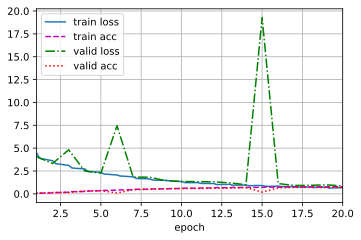

In [10]:
# 3.train
epochs, lr = 20, 1e-3
cf.train_image_valid(model, train_iter, valid_iter, epochs, lr, device='cuda')

In [11]:
train_dataset = MyDataset(train_dir, data_dir, transform=train_transforms, train=True)
test_iter = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
results = []

with torch.no_grad():
    for images, filenames in test_iter:
        images = images.to('cuda')
        preds = model(images).argmax(1).cpu().numpy()
        
        for filename, pred in zip(filenames, preds):
            label = train_dataset.idx_to_class[pred]
            results.append((filename, label))

# 保存结果
subfile = os.path.join(data_dir, "submission.csv")
pd.DataFrame(results, columns=["image", "label"]).to_csv(
    subfile, index=False, encoding="utf-8"
)

In [12]:
train_dataset.idx_to_class

{0: 'abies_concolor',
 1: 'abies_nordmanniana',
 2: 'acer_campestre',
 3: 'acer_ginnala',
 4: 'acer_griseum',
 5: 'acer_negundo',
 6: 'acer_palmatum',
 7: 'acer_pensylvanicum',
 8: 'acer_platanoides',
 9: 'acer_pseudoplatanus',
 10: 'acer_rubrum',
 11: 'acer_saccharinum',
 12: 'acer_saccharum',
 13: 'aesculus_flava',
 14: 'aesculus_glabra',
 15: 'aesculus_hippocastamon',
 16: 'aesculus_pavi',
 17: 'ailanthus_altissima',
 18: 'albizia_julibrissin',
 19: 'amelanchier_arborea',
 20: 'amelanchier_canadensis',
 21: 'amelanchier_laevis',
 22: 'asimina_triloba',
 23: 'betula_alleghaniensis',
 24: 'betula_jacqemontii',
 25: 'betula_lenta',
 26: 'betula_nigra',
 27: 'betula_populifolia',
 28: 'broussonettia_papyrifera',
 29: 'carpinus_betulus',
 30: 'carpinus_caroliniana',
 31: 'carya_cordiformis',
 32: 'carya_glabra',
 33: 'carya_ovata',
 34: 'carya_tomentosa',
 35: 'castanea_dentata',
 36: 'catalpa_bignonioides',
 37: 'catalpa_speciosa',
 38: 'cedrus_atlantica',
 39: 'cedrus_deodara',
 40: 'c

In [13]:
# save parameters
torch.save(model.state_dict(), os.path.join(data_dir, "resnet50model.pth"))